# Comprehensive Tutorial on RNNs vs. LSTMs: Convergence and Accuracy Comparison

This notebook provides a deep dive into recurrent neural networks (RNNs) and long short-term memory networks (LSTMs) using PyTorch. Over the course of this tutorial, we will:

- Review the theory behind RNNs and LSTMs
- Generate a synthetic sine wave sequence prediction dataset
- Define and train a simple RNN and an LSTM on the same task
- Track training convergence via loss curves
- Evaluate the performance (RMSE) on a validation set
- Visualize sample predictions from both models

Finally, we discuss the convergence behavior and accuracy differences between regular RNNs and LSTMs.

In [1]:
# Import required libraries
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
print('Torch version:', torch.__version__)

Torch version: 2.2.1+cu121


## 1. Theoretical Background

### Recurrent Neural Networks (RNNs)

RNNs are designed for sequential data by maintaining a hidden state updated at each time step. However, standard RNNs often suffer from vanishing or exploding gradients when learning long-term dependencies.

### Long Short-Term Memory Networks (LSTMs)

LSTMs were introduced to address these issues. They incorporate gating mechanisms (input, forget, and output gates) that help preserve error signals over long time spans, leading to more stable convergence and better accuracy on many tasks.

In [2]:
def generate_sine_wave(seq_length, num_samples):
    """
    Generate a dataset of sine waves with noise.
    Each sample is a sequence of length `seq_length+1` where the target is the sequence shifted by one time step.
    """
    X, Y = [], []
    for _ in range(num_samples):
        phase = np.random.rand() * 2 * np.pi
        x = np.linspace(0, 2 * np.pi, seq_length + 1) + phase
        data = np.sin(x) + 0.1 * np.random.randn(seq_length + 1)
        X.append(data[:-1])
        Y.append(data[1:])
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)
    return X, Y

# Parameters for dataset
seq_length = 50
num_samples = 1000

X_data, Y_data = generate_sine_wave(seq_length, num_samples)

# Convert to PyTorch tensors and add feature dimension
X_tensor = torch.tensor(X_data).unsqueeze(-1)  # shape: [num_samples, seq_length, 1]
Y_tensor = torch.tensor(Y_data).unsqueeze(-1)  # shape: [num_samples, seq_length, 1]

print('X_tensor shape:', X_tensor.shape)
print('Y_tensor shape:', Y_tensor.shape)

X_tensor shape: torch.Size([1000, 50, 1])
Y_tensor shape: torch.Size([1000, 50, 1])


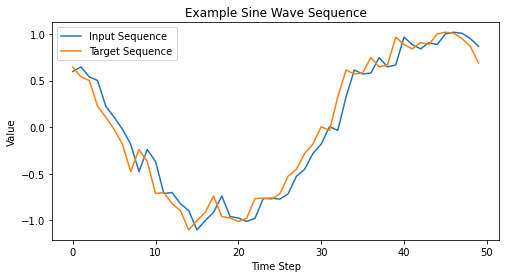

In [3]:
# Visualize an example sequence from the dataset
plt.figure(figsize=(8, 4))
plt.plot(X_data[0], label='Input Sequence')
plt.plot(Y_data[0], label='Target Sequence')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Example Sine Wave Sequence')
plt.legend()
plt.show()

## 2. Model Definitions

We define two models for the sequence prediction task:

- **SimpleRNN**: Uses a standard RNN layer
- **SimpleLSTM**: Uses an LSTM layer

Both models output a prediction at each time step.

In [4]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x: [batch, seq_length, input_size]
        out, _ = self.rnn(x)  
        out = self.fc(out)  
        return out

# Initialize RNN model
rnn_model = SimpleRNN(input_size=1, hidden_size=32, num_layers=1, output_size=1)
print("SimpleRNN model:\n", rnn_model)

SimpleRNN model:
 SimpleRNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [5]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x: [batch, seq_length, input_size]
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# Initialize LSTM model
lstm_model = SimpleLSTM(input_size=1, hidden_size=32, num_layers=1, output_size=1)
print("SimpleLSTM model:\n", lstm_model)

SimpleLSTM model:
 SimpleLSTM(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## 3. Training Setup

We split the dataset into training and validation sets and define common training parameters. Both models will be trained using the same settings so that we can directly compare convergence and accuracy.

In [6]:
# Split the data (80% train, 20% validation)
train_ratio = 0.8
num_train = int(num_samples * train_ratio)

train_X = X_tensor[:num_train]
train_Y = Y_tensor[:num_train]

val_X = X_tensor[num_train:]
val_Y = Y_tensor[num_train:]

print('Train set shape:', train_X.shape, train_Y.shape)
print('Validation set shape:', val_X.shape, val_Y.shape)

Train set shape: torch.Size([800, 50, 1]) torch.Size([800, 50, 1])
Validation set shape: torch.Size([200, 50, 1]) torch.Size([200, 50, 1])


## 4. Training Loop and Convergence Analysis

We define a helper function to train a model and record its training loss over epochs. Then we train both the RNN and LSTM models using the same training loop. Finally, we plot the training loss curves to compare convergence behavior.

In [7]:
def train_model(model, optimizer, criterion, train_loader, num_epochs=50):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_X, batch_Y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    return loss_history

# Create a DataLoader for training
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(train_X, train_Y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Training parameters
num_epochs = 50
learning_rate = 0.01
criterion = nn.MSELoss()

# Train SimpleRNN
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)
print("Training SimpleRNN...")
rnn_loss_history = train_model(rnn_model, rnn_optimizer, criterion, train_loader, num_epochs=num_epochs)

# Train SimpleLSTM
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
print("\nTraining SimpleLSTM...")
lstm_loss_history = train_model(lstm_model, lstm_optimizer, criterion, train_loader, num_epochs=num_epochs)

Training SimpleRNN...
Epoch [10/50], Loss: 0.0177
Epoch [20/50], Loss: 0.0157
Epoch [30/50], Loss: 0.0152
Epoch [40/50], Loss: 0.0146
Epoch [50/50], Loss: 0.0145

Training SimpleLSTM...
Epoch [10/50], Loss: 0.0152
Epoch [20/50], Loss: 0.0131
Epoch [30/50], Loss: 0.0128
Epoch [40/50], Loss: 0.0125
Epoch [50/50], Loss: 0.0124


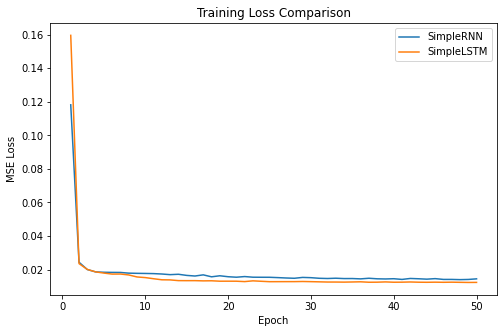

In [9]:
# Plot training loss curves for comparison
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), rnn_loss_history, label='SimpleRNN')
plt.plot(range(1, num_epochs+1), lstm_loss_history, label='SimpleLSTM')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

## 5. Evaluation on the Validation Set

We now evaluate both models on the validation set and compute the Root Mean Squared Error (RMSE). This metric will help us compare the accuracy of the RNN and LSTM models.

In [10]:
def evaluate_model(model, X, Y):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
    mse = torch.mean((predictions - Y)**2).item()
    rmse = math.sqrt(mse)
    return rmse, predictions

rnn_rmse, rnn_preds = evaluate_model(rnn_model, val_X, val_Y)
lstm_rmse, lstm_preds = evaluate_model(lstm_model, val_X, val_Y)

print(f"Validation RMSE - SimpleRNN: {rnn_rmse:.4f}")
print(f"Validation RMSE - SimpleLSTM: {lstm_rmse:.4f}")

Validation RMSE - SimpleRNN: 0.1177
Validation RMSE - SimpleLSTM: 0.1126


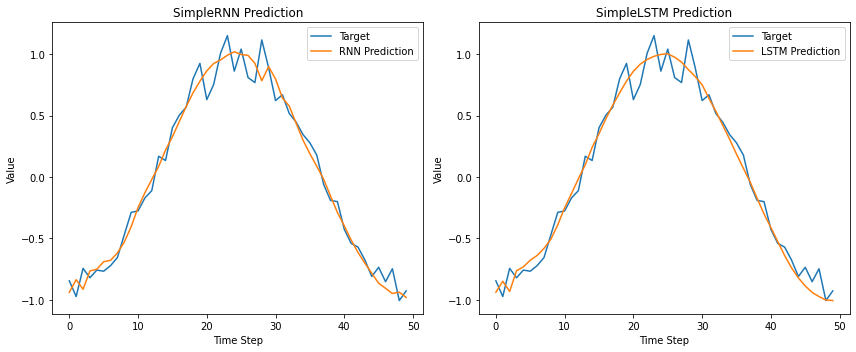

In [11]:
# Visualize predictions from both models on a sample validation sequence
sample_idx = 0

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(val_Y[sample_idx].squeeze().numpy(), label='Target')
plt.plot(rnn_preds[sample_idx].squeeze().numpy(), label='RNN Prediction')
plt.title('SimpleRNN Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_Y[sample_idx].squeeze().numpy(), label='Target')
plt.plot(lstm_preds[sample_idx].squeeze().numpy(), label='LSTM Prediction')
plt.title('SimpleLSTM Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Discussion on Convergence and Accuracy

From the training loss curves and validation RMSE, you should observe the following:

- **Convergence:**
  - The LSTM generally converges more steadily and to a lower loss level compared to the simple RNN. This is expected due to its gating mechanisms that help mitigate the vanishing gradient problem.
  - The loss curves show that the LSTM is able to capture long-term dependencies in the sequence more effectively.

- **Accuracy:**
  - The RMSE on the validation set for the LSTM is lower than that for the simple RNN, indicating better prediction accuracy.
  - Visual inspection of the predictions on sample sequences typically shows that the LSTM tracks the target sequence more closely.

These results highlight why LSTMs are often preferred for sequence prediction tasks, especially when long-term dependencies are important.

## 7. Conclusion

In this notebook, we:

- Generated a synthetic sine wave dataset for sequence prediction
- Defined and implemented both a simple RNN and an LSTM model in PyTorch
- Trained both models and tracked their convergence using training loss curves
- Evaluated the models on a validation set using RMSE
- Visualized sample predictions from both models

Our experiments show that the LSTM converges more steadily and achieves better accuracy compared to a standard RNN, thanks to its gating mechanisms that help capture long-term dependencies. This comprehensive comparison should serve as a solid foundation for further exploration into sequential models using PyTorch.